# Phase 1 - Ingestion and Cleaning

This notebook carries out the following steps
  - Ingest data downloaded from the LendingClub website
  - Compare it to an earlier cut of the data, to identify columns that are not changing
  - Output a combined dataset ready for analysis

In [1]:
import pandas as pd
import os
from sys import platform
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pickle
import seaborn

In [2]:
def is_integer(x):
    '''
    This function returns True if x is an integer, and False otherwise
    '''
    try:
        return (int(x) == float(x))
    except:
        return False

## Parameters

In [3]:
# Define the directories that contain the files downloaded in 2017
# and 2018
dir_2017 = "/".join( ['..'] + ["Data"] + ["1712_download"] )
dir_2018 = "/".join( ['..'] + ["Data"] + ["1805_download"] )

# Define the output path for the pickle
pickle_file = "/".join( ['..'] + ["Data"] + ["clean_data.pickle"] )

In [4]:
# Identify the columns we'll be keeping from the dataset
cols_to_pick = ['id','loan_amnt','funded_amnt','term','int_rate',
                 'installment','grade','emp_length', 'home_ownership',
                 'annual_inc','verification_status','issue_d',
                 'loan_status','purpose','dti', 'delinq_2yrs',
                 'earliest_cr_line','open_acc','pub_rec', 'fico_range_high',
                 'fico_range_low', 'revol_bal','revol_util', 'total_pymnt',
                                                    'last_pymnt_d', 'recoveries']

# Identify the type of each of these column
float_cols = ['loan_amnt', 'funded_amnt', 'installment', 'annual_inc',
                     'dti', 'revol_bal', 'delinq_2yrs', 'open_acc', 'pub_rec',
                                'fico_range_high', 'fico_range_low', 'total_pymnt', 'recoveries']
cat_cols = ['term', 'grade', 'emp_length', 'home_ownership',
                    'verification_status', 'loan_status', 'purpose']
perc_cols = ['int_rate', 'revol_util']
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']

# Ensure that we have types for every column
assert set(cols_to_pick) - set(float_cols) - set(cat_cols) - set(perc_cols) - set(date_cols) == set(["id"])

In [5]:
# Some of the columns selected will not be used directly in the model,
# but will be used to generate other features.
#
# Create variables specifying the features that will be used

# All categorical columns other than "loan_status" will be used as
# discrete features
discrete_features = list(set(cat_cols) - set(["loan_status"]))

# All numeric columns will be used as continuous features
continuous_features = list(float_cols + perc_cols)

## Step 1 - Ingestion
Ingest the data files from both sets, perform consistency checks, and prepare one single file for each set

In [6]:
def ingest_files(directory):
    '''
    This function will ingest every file in the specified directory
    into a pandas dataframe. It will return a dictionary containing
    these dataframes, keyed by the file name.
    
    We assume the directory contains files directly downloaded from
    MC, and *only* those files. Thus, we assume the files are zipped
    (pd.read_csv can read zipped files) and we assume the first line
    in each file needs to be skipped
    
    Note that each file will be read *without* formatting
    '''
    
    # If the directory has no trailing slash, add one
    if directory[-1] != "/":
        directory = directory + "/"
    
    all_files = os.listdir(directory)
    output = {}
    
    print("Directory " + directory + " has " + str(len(all_files)) + " files:")
    for i in all_files:
        print("    Reading file " + i)
        output[i] = pd.read_csv(directory + i, dtype = str, skiprows = 1)
        
        # Some of the files have "summary" lines that, for example
        # read "Total number of loans number in Policy 1: ....."
        # To remove those lines, find any lines with non-integer IDs
        # and remove them
        invalid_rows = (output[i].id.apply( lambda x : is_integer(x) == False ))
        if invalid_rows.sum() > 0:
            print("        Found " + str(invalid_rows.sum()) + " invalid rows which were removed")
            output[i] = output[i][invalid_rows == False]
    
    return output

In [7]:
# Ingest the set of files we downloaded in 2017 and then the files we
# downloaded in 2018
files_2017 = ingest_files(dir_2017)
files_2018 = ingest_files(dir_2018)

Directory ../Data/1712_download/ has 12 files:
    Reading file LoanStats_securev1_2016Q3.csv.zip
        Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q2.csv.zip
        Found 2 invalid rows which were removed
    Reading file LoanStats3a_securev1.csv.zip
        Found 3 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q1.csv.zip
        Found 2 invalid rows which were removed
    Reading file LoanStats3d_securev1.csv.zip
        Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q3.csv.zip
        Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q2.csv.zip
        Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q1.csv.zip
        Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q4.csv.zip
        Found 2 invalid rows which were removed
    Reading file LoanStats3c_securev1.csv.zip
        Found 2 invalid ro

### Carry out consistency checks

In [8]:
# Check the two sets of files have the same number of files
# with the same names
assert len(files_2017) == len(files_2018)
assert sorted(files_2017) == sorted(files_2018)

In [9]:
# Ensure every file has the same headers, in both sets
x = set( [tuple(i.columns) for i in files_2017.values()] 
                + [tuple(i.columns) for i in files_2018.values()] )
assert len(x) == 1

In [10]:
# Ensure each set of files has the same loan IDs in both
# instances
for i in files_2017:
    assert sorted(files_2017[i].id) == sorted(files_2018[i].id)

### Combine the files

In [11]:
data_2017 = pd.concat(files_2017.values()).reset_index(drop = True)
data_2018 = pd.concat(files_2018.values()).reset_index(drop = True)

In [12]:
# Ensure the loan IDs are a unique key
assert len(set(data_2018.id)) == len(data_2018)

## Step 2 - find static columns
Find columns that were static in both sets of files

In [13]:
columns = list(data_2017.columns)

# We verified every file had the same columns, but double check just
# in case
assert sorted(columns) == sorted(data_2018.columns)

In [14]:
# Join the files. Because we have previously confirmed that each
# set of files contained the same sets of IDs *and* that these
# IDs were unique, the two files can be joined safely

# Just in case, check the datasets have the same number of rows
n_rows = len(data_2017)
assert n_rows == len(data_2018)

# Merge them
combined = pd.merge(data_2017, data_2018, how = 'inner', on="id", suffixes=('_x', '_y'))

# Ensure the merged dataset has the same number of rows
assert n_rows == len(combined)

In [15]:
# Go through each column, and find what percentage of the values in
# that column are identical in the two datasets
static_perc = {}

# Remove the ID column first
columns = [i for i in columns if i != "id"]

for i in columns:
    combined[i+"_comp"] = (combined[i+"_x"] == combined[i+"_y"]) | (combined[i+"_x"].isnull() & combined[i+"_y"].isnull())
    static_perc[i] = combined[i+"_comp"].sum()*100.0/len(combined)

In [16]:
static_perc = pd.DataFrame([ [i, static_perc[i]] for i in static_perc], columns=["column", "perc_equal"]).\
                                                    sort_values("perc_equal", ascending = False)

In [17]:
# Ensure that the columns we want to pick for our model are in
# the above, and check how consistent they've been
assert set(cols_to_pick) - set(static_perc.column) - set(["id"]) == set()

static_perc[static_perc.column.isin(cols_to_pick)]

,column,perc_equal
1,loan_amnt,100.000000
34,revol_util,100.000000
32,pub_rec,100.000000
31,open_acc,100.000000
27,fico_range_high,100.000000
26,fico_range_low,100.000000
25,earliest_cr_line,100.000000
24,delinq_2yrs,100.000000
23,dti,100.000000
19,purpose,100.000000


In [18]:
#Consider the columns that were no consistent in both datasets
#  - We expect loan_status to change, as payments are made
#  - int_rate and installment are somewhat more worrying; let's examine them

# First, make sure the columns in which int_rate and installment
# are different are the same columns
assert (combined["int_rate_comp"] != combined["installment_comp"]).sum() == 0

In [19]:
# So the differences in int_rate and installment are the same. Let's
# look at them to make sure they're OK
combined[combined.int_rate_comp == False][["id", "issue_d_x", "issue_d_y", "term_x", "term_y", "int_rate_x", "int_rate_y"]]

,id,issue_d_x,issue_d_y,term_x,term_y,int_rate_x,int_rate_y
91912,84939204,Jul-2016,Jul-2016,60 months,60 months,23.99%,6.00%
134595,78923321,May-2016,May-2016,36 months,36 months,17.27%,6.00%
282052,97459138,Feb-2017,Feb-2017,36 months,36 months,13.49%,6.00%
400941,65087883,Nov-2015,Nov-2015,36 months,36 months,17.86%,6.00%
413343,63867478,Nov-2015,Nov-2015,36 months,36 months,12.59%,6.00%
457466,61519878,Oct-2015,Oct-2015,60 months,60 months,23.99%,6.00%
466343,60802457,Sep-2015,Sep-2015,60 months,60 months,16.55%,6.00%
838499,114206804,Aug-2017,Aug-2017,60 months,60 months,9.44%,6.00%
879563,111651514,Jul-2017,Jul-2017,60 months,60 months,16.02%,6.00%
968907,105792120,Apr-2017,Apr-2017,60 months,60 months,26.24%,6.00%


In [21]:
# This is not ideal - it looks like the interest rate sometimes
# changes *after* the loan is issued. It is therefore somewhat
# dubious to use the interest rate as provided in the latest file
# to make default prediction. Nevertheless, because this occurs
# in so few loans, we will ignore this issue

## Step 3 - Prepare Final Dataset

In [20]:
# Keep only the columns of interest
final_data = data_2018[cols_to_pick].copy()

In [21]:
print("Starting with " + str(len(final_data)) + " rows")

Starting with 1765426 rows


### Typecast the columns

In [22]:
for i in float_cols:
    final_data[i] = final_data[i].astype(float)
    
def clean_perc(x):
    if pd.isnull(x):
        return np.nan
    else:
        return float(x.strip()[:-1])
for i in perc_cols:
    final_data[i] = final_data[i].apply( clean_perc )
    
def clean_date(x):
    if pd.isnull(x):
        return None
    else:
        return datetime.datetime.strptime( x, "%b-%Y").date()
for i in date_cols:
    final_data[i] = final_data[i].apply( clean_date )
    
for i in cat_cols:
    final_data.loc[final_data[i].isnull(), i] = None

## Calculate returns for each loan

In [23]:
# Define the names of the four returns we'll be calculating
ret_cols = ["ret_PESS", "ret_OPT", "ret_INTa", "ret_INTb", "ret_INTc"]

In [24]:
# Remove all rows for loans that were paid back on the days
# they were issued
final_data['loan_length'] = (final_data.last_pymnt_d - final_data.issue_d) / np.timedelta64(1, 'M')
n_rows = len(final_data)
final_data = final_data[final_data.loan_length != 0]
print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 6218 rows


#### Return Method 2 (pessimistic)

In [25]:
# Calculate the return using a simple annualized profit margin
# Pessimistic fefinition (method 2)

final_data['term_num'] = final_data.term.str.extract('(\d+)',expand=False).astype(int)
final_data['ret_PESS'] = ( (final_data.total_pymnt - final_data.funded_amnt) 
                                            / final_data.funded_amnt ) * (12 / final_data['term_num'])

#### Return Method 1 (optimistic)

In [26]:
# Assuming that if a loan gives a positive return, we can
# immediately find a similar loan to invest in; if the loan
# takes a loss, we use method 2 to compute the return

final_data['ret_OPT'] = ( (final_data.total_pymnt - final_data.funded_amnt)
                                            / final_data.funded_amnt ) * (12 / final_data['loan_length'])
final_data.loc[final_data.ret_OPT < 0,'ret_OPT'] = final_data.ret_PESS[final_data.ret_OPT < 0]

#### Return Method 3 (re-investment)

In [27]:
def ret_method_3(T, i):
    '''
    Given an investment time horizon (in months) and re-investment
    interest rate, calculate the return of each loan
    '''
    
    # Assuming that the total amount paid back was paid at equal
    # intervals during the duration of the loan, calculate the
    # size of each of these installment
    actual_installment = (final_data.total_pymnt - final_data.recoveries) / final_data['loan_length']

    # Assuming the amount is immediately re-invested at the prime
    # rate, find the total amount of money we'll have by the end
    # of the loan
    cash_by_end_of_loan = actual_installment * (1 - pow(1 + i, final_data.loan_length)) / ( 1 - (1 + i) )
    
    cash_by_end_of_loan = cash_by_end_of_loan + final_data.recoveries
    
    # Assuming that cash is then re-invested at the prime rate,
    # with monthly re-investment, until T months from the start
    # of the loan
    remaining_months = T - final_data['loan_length']
    final_return = cash_by_end_of_loan * pow(1 + i, remaining_months)

    # Find the percentage return
    return( (12/T) * ( ( final_return - final_data['funded_amnt'] ) / final_data['funded_amnt'] ) )

final_data['ret_INTa'] = ret_method_3(5*12, 0.001)
final_data['ret_INTb'] = ret_method_3(5*12, 0.0025)
final_data['ret_INTc'] = ret_method_3(5*12, 0.005)

### Visualize the variables

In [28]:
def visualize_columns():
    '''
    This function visualizes all columns
      - Box-and-whisker plots for continuous variables
      - Lists of distinct values for categorical columns
      - A timeline density for dates
    '''
    
    # FLoat columns
    for i in float_cols + perc_cols + ret_cols:
        seaborn.boxplot(final_data[i])

        # Print the three highest values
        highest_vals = sorted(final_data[i], reverse=True)[:3]
        smallest_val = min(final_data[i])
        plt.text(smallest_val, -0.3, highest_vals[0])
        plt.text(smallest_val, -0.2, highest_vals[1])
        plt.text(smallest_val, -0.1, highest_vals[2])

        plt.show()
        
    # Categorical columns 
    for i in cat_cols:
        print(i)
        print(str(len(set(final_data[i]))) + " distinct values")
        print(final_data[i].value_counts())
        print("")
        print("")
    
    # Date columns
    for i in date_cols:
        final_data[final_data[i].isnull() == False][i].apply(lambda x : str(x.year) +
                                                "-" + str(x.month)).value_counts(ascending = True).plot()
        plt.title(i + " (" + str(final_data[i].isnull().sum()) + " null values)")
        plt.show()

/Users/jeol/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


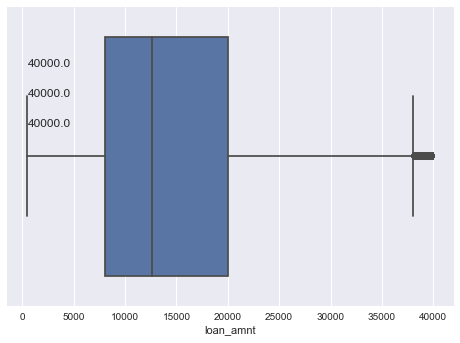

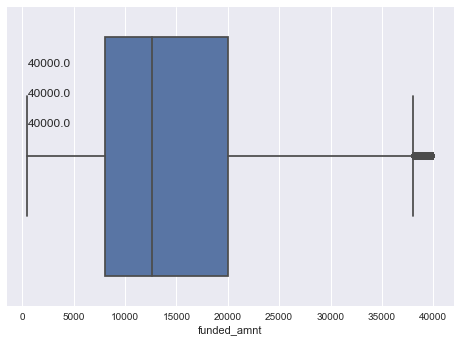

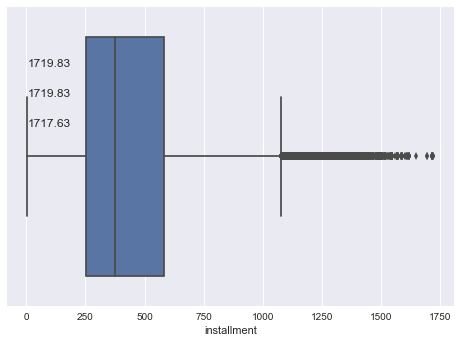

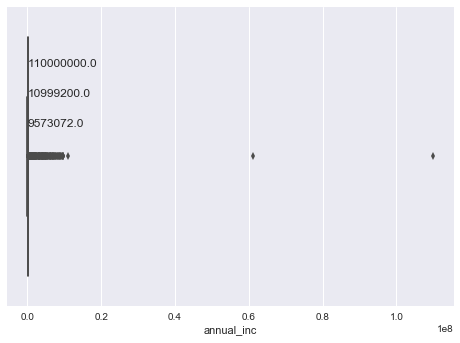

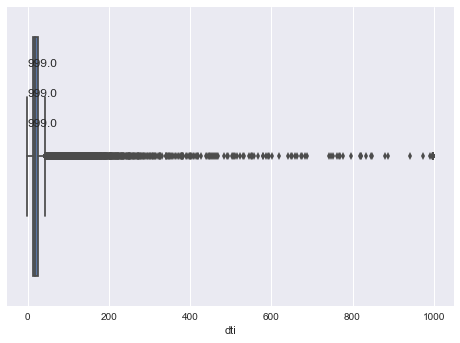

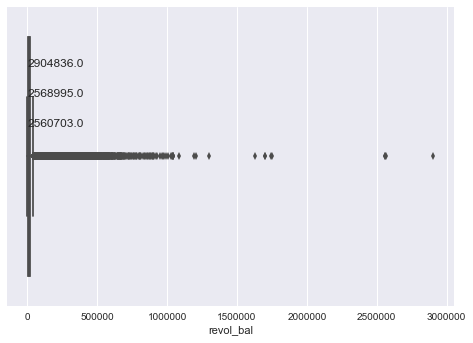

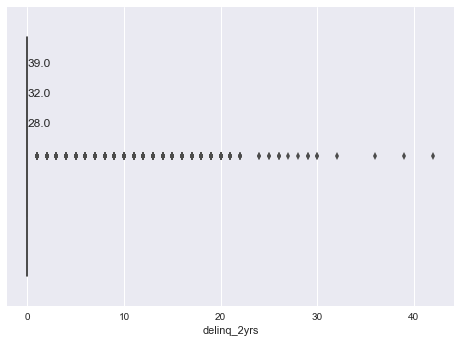

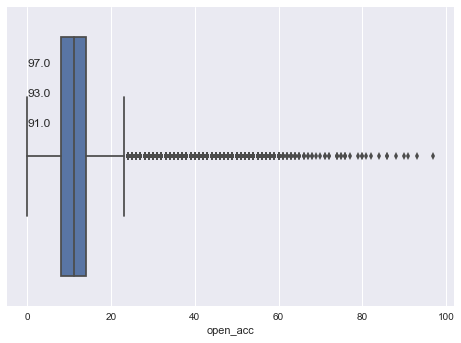

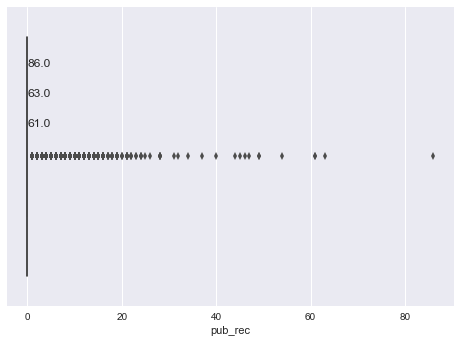

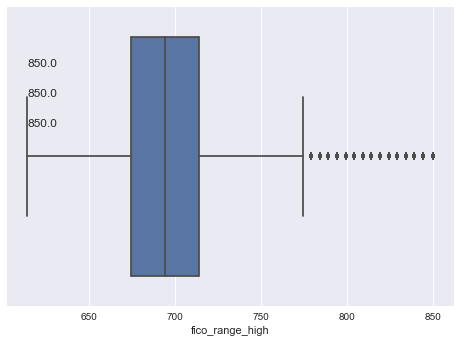

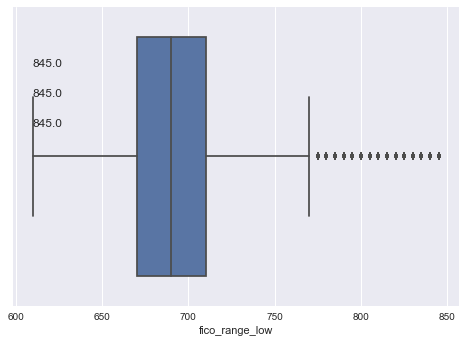

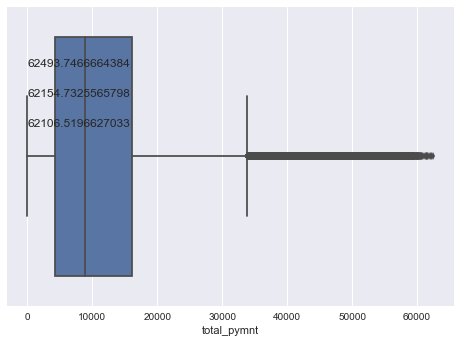

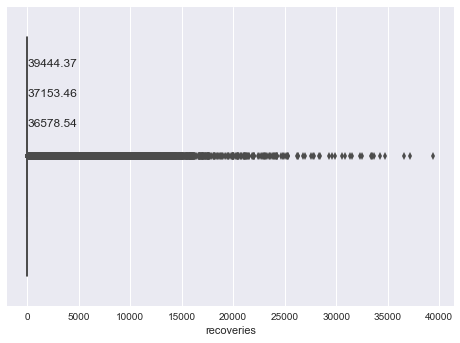

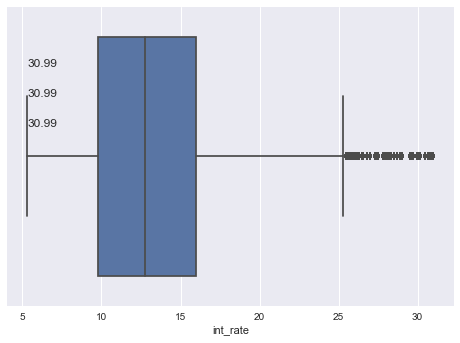

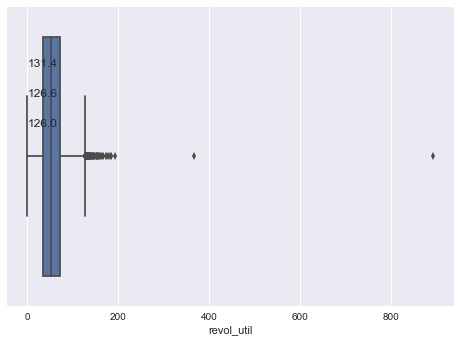

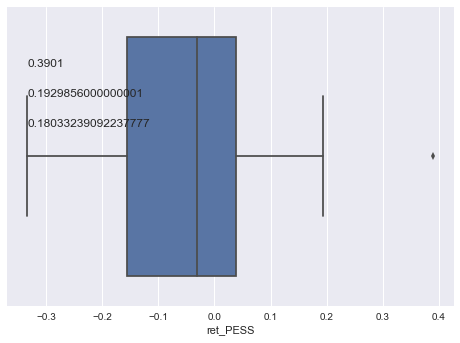

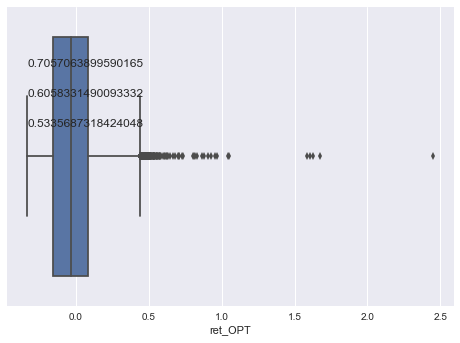

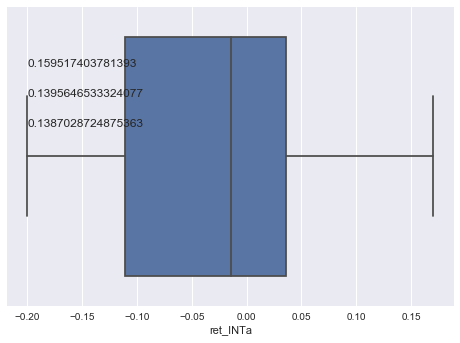

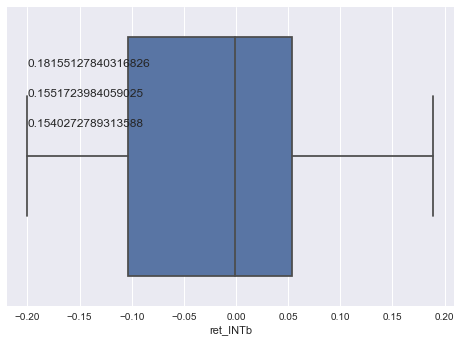

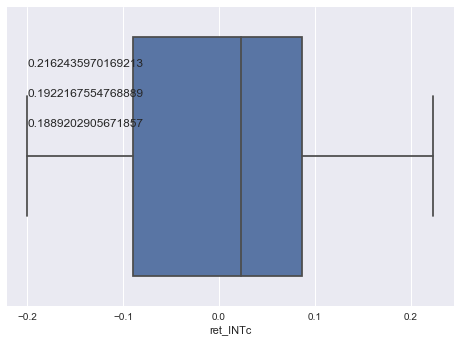

term
2 distinct values
 36 months    1260610
 60 months     498598
Name: term, dtype: int64


grade
7 distinct values
C    521315
B    520527
A    296996
D    254390
E    116174
F     38424
G     11382
Name: grade, dtype: int64


emp_length
12 distinct values
10+ years    585453
2 years      158386
< 1 year     145876
3 years      139611
1 year       114808
5 years      108455
4 years      105001
6 years       80425
8 years       75648
7 years       74482
9 years       66527
Name: emp_length, dtype: int64


home_ownership
6 distinct values
MORTGAGE    869367
RENT        697215
OWN         191886
ANY            504
OTHER          182
NONE            54
Name: home_ownership, dtype: int64


verification_status
3 distinct values
Source Verified    668294
Not Verified       561817
Verified           529097
Name: verification_status, dtype: int64


loan_status
9 distinct values
Current                                                792304
Fully Paid                                           

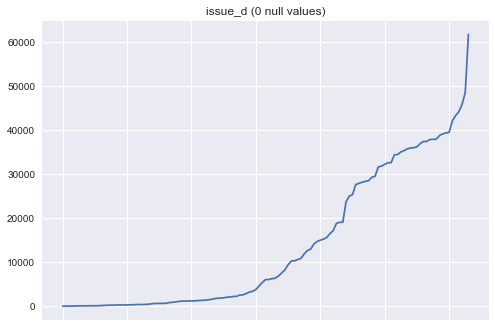

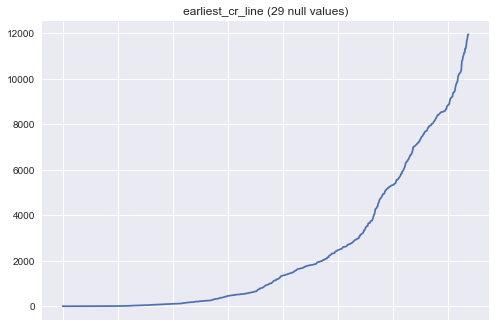

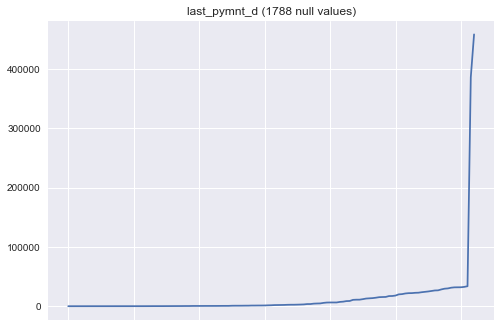

In [29]:
visualize_columns()

### Handle outliers

In [30]:
# There are quite a few outliers, but the two most obvious
# ones to remove are in annual_inc, revol_util Remove these.
n_rows = len(final_data)
final_data = final_data[final_data.annual_inc < 10999200]
final_data = final_data[final_data.revol_util < 300]
print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 1214 rows


In [31]:
# Remove all loans that are too recent to have been paid off or
# defaulted
n_rows = len(final_data)
final_data = final_data[final_data.loan_status.isin(['Fully Paid','Charged Off','Default'])]
print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 829369 rows


In [32]:
# Only include loans isssued since 2009
n_rows = len(final_data)
final_data = final_data[final_data.issue_d >= datetime.date(2009, 1, 1)]
print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 1805 rows


/Users/jeol/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


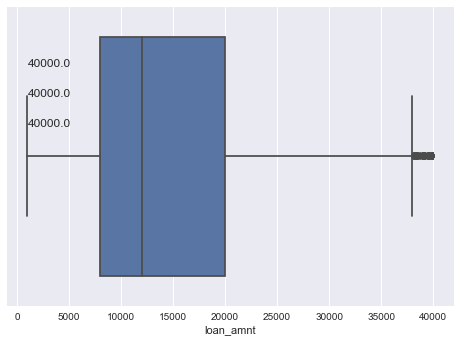

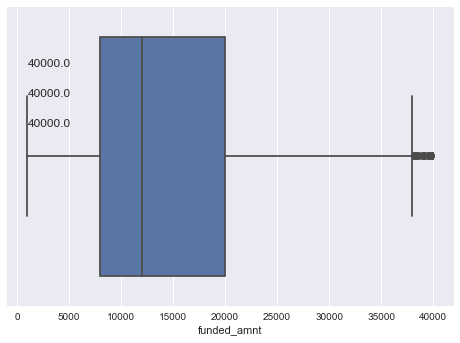

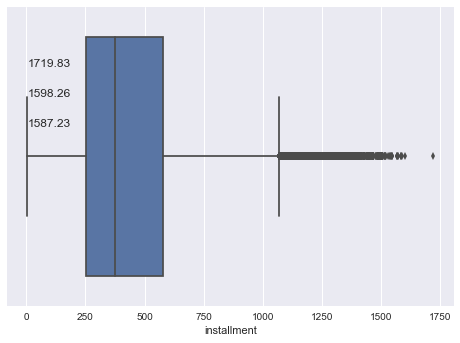

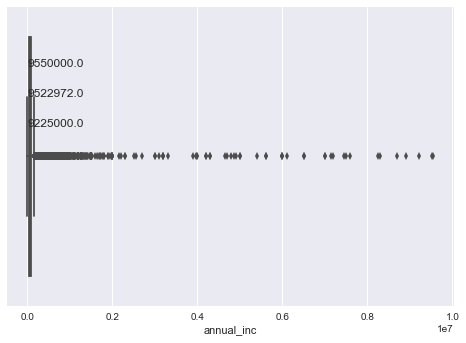

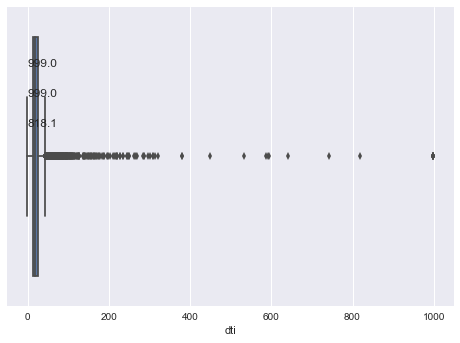

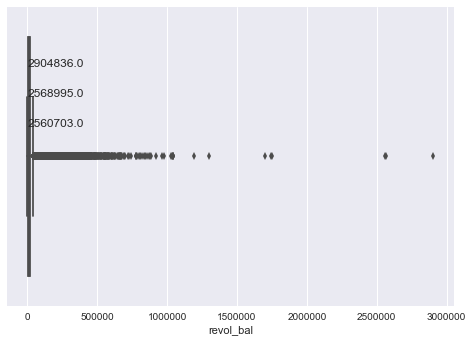

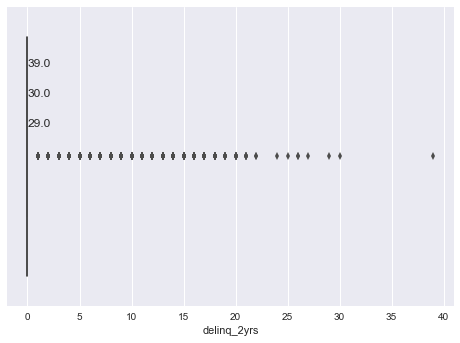

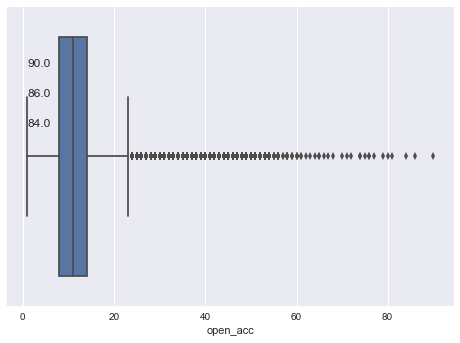

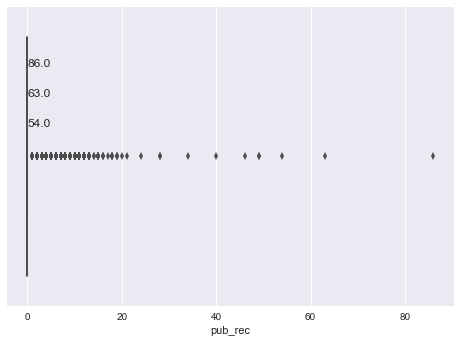

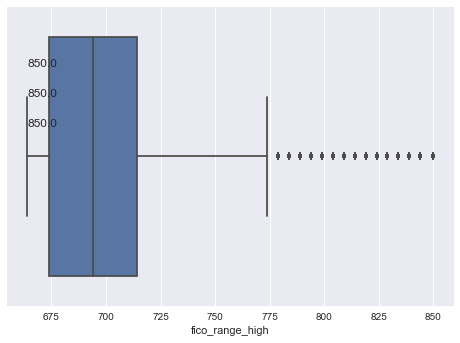

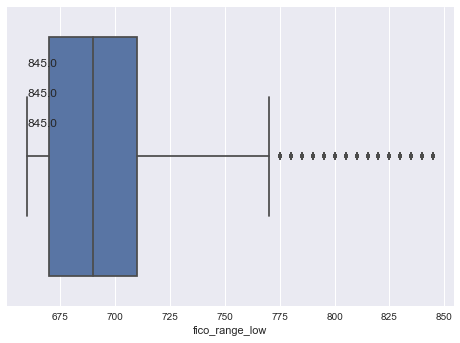

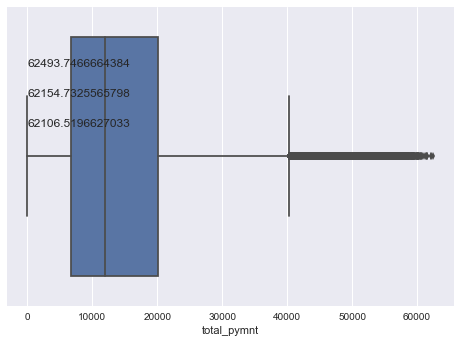

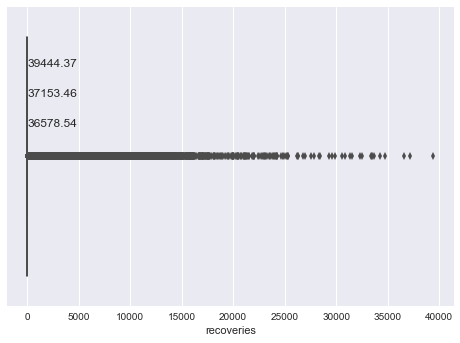

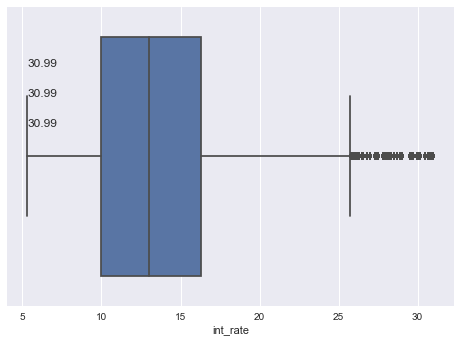

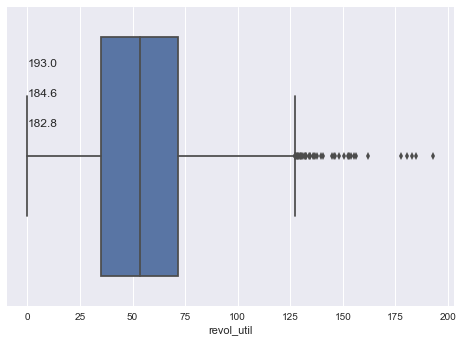

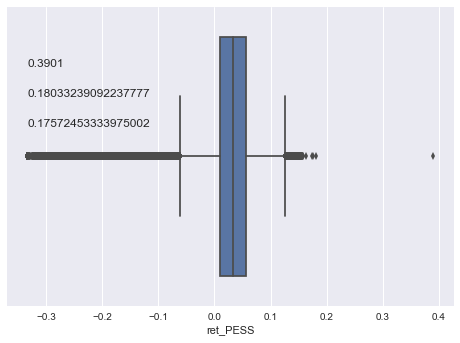

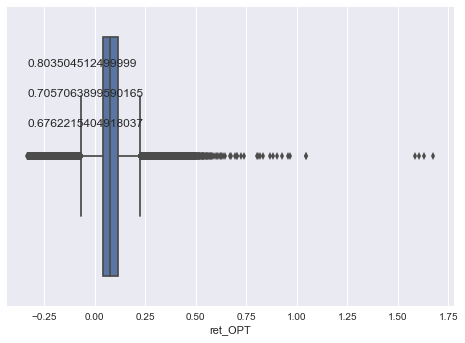

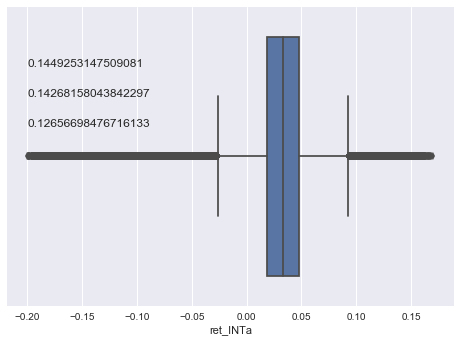

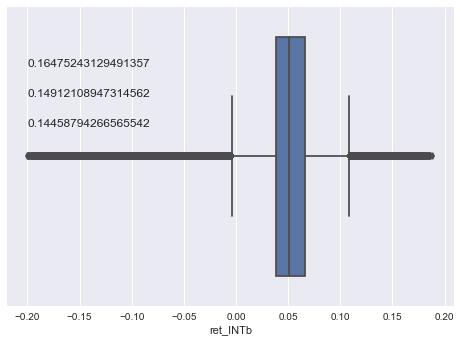

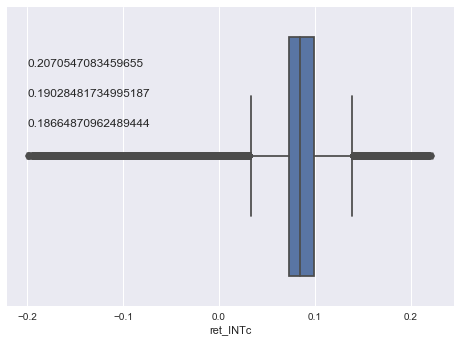

term
2 distinct values
 36 months    703675
 60 months    223145
Name: term, dtype: int64


grade
7 distinct values
B    267393
C    259246
A    154547
D    143169
E     70461
F     25251
G      6753
Name: grade, dtype: int64


emp_length
12 distinct values
10+ years    302143
2 years       83986
3 years       73979
< 1 year      73481
1 year        60717
5 years       58904
4 years       55531
6 years       45184
8 years       43789
7 years       43771
9 years       36062
Name: emp_length, dtype: int64


home_ownership
6 distinct values
MORTGAGE    461527
RENT        369951
OWN          95059
ANY            122
OTHER          117
NONE            44
Name: home_ownership, dtype: int64


verification_status
3 distinct values
Source Verified    339888
Verified           302635
Not Verified       284297
Name: verification_status, dtype: int64


loan_status
3 distinct values
Fully Paid     734901
Charged Off    191528
Default           391
Name: loan_status, dtype: int64


purpose
14 distin

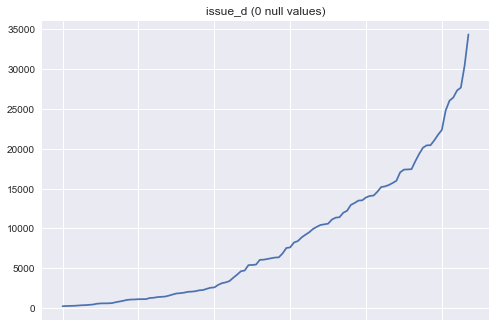

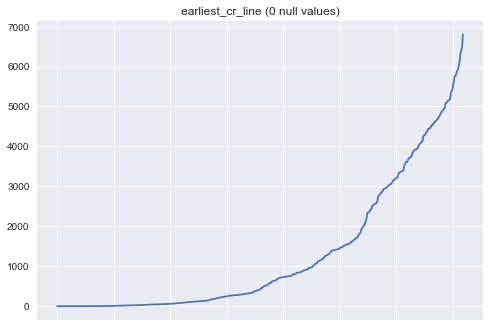

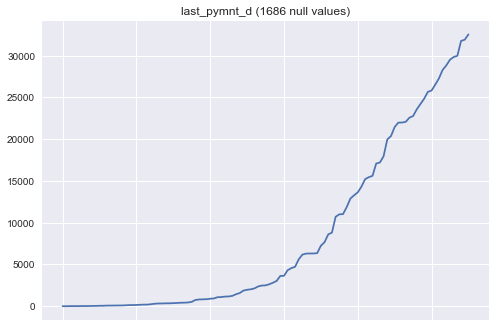

In [33]:
# Visualize the data again
visualize_columns()

### Drop null values

In [34]:
# Deal with null values. We allow cateogrical variables to be null
# OTHER than grade, which is a particularly important categorical.
# All non-categorical variables must be non-null, and we drop
# rows that do not meet this requirement
required_cols = set(cols_to_pick) - set(cat_cols) - set(["id"])
required_cols.add("grade")

n_rows = len(final_data)
final_data.dropna(subset = required_cols ,inplace=True)
print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 1752 rows


## Step 4 - Data Exploration

In [35]:
# Find the percentage of loans by grade, the default by grade,
# and the return of each grade
perc_by_grade = (final_data.grade.value_counts()*100/len(final_data)).sort_index()
default_by_grade = final_data.groupby("grade").apply(lambda x : (x.loan_status != "Fully Paid").sum()*100/len(x) )
ret_by_grade_OPT = final_data.groupby("grade").apply(lambda x : np.mean(x.ret_OPT)*100 )
ret_by_grade_PESS = final_data.groupby("grade").apply(lambda x : np.mean(x.ret_PESS)*100 )
ret_by_grade_INTa = final_data.groupby("grade").apply(lambda x : np.mean(x.ret_INTa)*100 )
ret_by_grade_INTb = final_data.groupby("grade").apply(lambda x : np.mean(x.ret_INTb)*100 )
ret_by_grade_INTc = final_data.groupby("grade").apply(lambda x : np.mean(x.ret_INTc)*100 )
int_rate_by_grade = final_data.groupby("grade").apply(lambda x : np.mean(x.int_rate))

combined = pd.DataFrame(perc_by_grade)
combined['default'] = default_by_grade
combined['int_rate'] = int_rate_by_grade
combined['return_OPT'] = ret_by_grade_OPT
combined['return_PESS'] = ret_by_grade_PESS
combined['return_INTa'] = ret_by_grade_INTa
combined['return_INTb'] = ret_by_grade_INTb
combined['return_INTc'] = ret_by_grade_INTc

combined

,grade,default,int_rate,return_OPT,return_PESS,return_INTa,return_INTb,return_INTc
A,16.695638,6.362094,7.223694,3.887175,1.667033,2.052092,3.714742,6.773299
B,28.875283,13.558903,10.851595,5.008395,1.576205,2.016156,3.682079,6.747994
C,27.972863,22.573116,14.071666,5.392923,0.615351,1.390038,3.024004,6.033807
D,15.433352,30.583670,17.536599,5.708468,0.051308,0.920507,2.514594,5.450665
E,7.585280,39.108438,20.719619,5.947793,-0.906711,0.107812,1.640767,4.465373
F,2.715152,45.347772,24.452893,6.428319,-1.427023,-0.437295,1.054263,3.803446
G,0.722433,48.975011,27.070105,6.664425,-2.582140,-1.397466,0.053721,2.733060


## Step 5 - Save a Pickle

In [39]:
# Remove the total_pymnt from the list of continuous features; this
# variable is highly predictive of the outcome but is not known at
# the time the loan is issued
continuous_features = [i for i in continuous_features if i not in ["total_pymnt", "recoveries"]]

In [43]:
pickle.dump( [final_data, discrete_features, continuous_features, ret_cols], open(pickle_file, "wb") )

## Extra step: verify that recoveries is included in total payment 

In [4]:
# Since the file of original payment data is huge, we use an iterator
# to load only part of the data
reader = pd.read_csv('../Data/PMTHIST_ALL_2018_06.zip',low_memory=False,iterator=True)
df_sample = reader.get_chunk(200000)
df_sample[(~np.isnan(df_sample.PCO_RECOVERY))]

,LOAN_ID,PBAL_BEG_PERIOD,PRNCP_PAID,INT_PAID,FEE_PAID,DUE_AMT,RECEIVED_AMT,RECEIVED_D,PERIOD_END_LSTAT,MONTH,...,MonthsSinceLastRec,EmploymentLength,currentpolicy,grade,term,APPL_FICO_BAND,Last_FICO_BAND,VINTAGE,PCO_RECOVERY,PCO_COLLECTION_FEE
142,56413,6216.378467,0.0,0.0,0.00,1315.20,0.00,NaN,Charged Off,JUN2009,...,0.0,10+ years,0,F,36,645-649,LOW-499,08Q2,0.25,0.0450
180,57167,23365.347966,0.0,0.0,0.00,4500.56,0.00,NaN,Charged Off,APR2015,...,NaN,1 year,1,D,36,660-664,600-604,14Q3,3354.94,603.8892
407,61419,360.206094,0.0,0.0,0.00,382.67,0.00,NaN,Charged Off,MAR2013,...,63.0,1 year,1,D,36,665-669,LOW-499,10Q1,43.57,1.0600
448,62774,2924.168996,0.0,0.0,0.00,716.97,0.00,NaN,Charged Off,AUG2009,...,0.0,1 year,0,F,36,675-679,LOW-499,08Q1,133.43,1.3900
478,64949,2477.557558,0.0,0.0,0.00,1210.25,0.00,NaN,Charged Off,OCT2010,...,0.0,< 1 year,0,E,36,650-654,LOW-499,08Q2,0.70,0.0000
497,65104,3619.108468,0.0,0.0,0.00,1612.65,0.00,NaN,Charged Off,DEC2017,...,NaN,2 years,1,D,36,660-664,LOW-499,16Q2,507.72,91.3896
557,65426,1829.316151,0.0,0.0,0.00,524.88,0.00,NaN,Charged Off,OCT2011,...,0.0,< 1 year,1,B,36,720-724,505-509,09Q3,0.42,0.0000
570,65595,4071.483712,0.0,0.0,0.00,864.45,0.00,NaN,Charged Off,JUL2009,...,NaN,3 years,0,E,36,650-654,505-509,08Q2,173.05,60.5700
838,67477,4995.003580,0.0,0.0,0.00,1556.00,0.00,NaN,Charged Off,MAR2010,...,NaN,< 1 year,0,E,36,655-659,510-514,08Q2,1.62,0.0000
1825,72323,4032.804485,0.0,0.0,0.00,1193.66,0.00,NaN,Charged Off,DEC2008,...,NaN,9 years,0,C,36,695-699,LOW-499,07Q3,182.33,1.8400


As we can see from the table above, this dataframe contains loans with non-zero recoveries entries (PCO_RECOVERY). To verify that these recoveries were included in the total payment, we need to pull out an loan and compare the value to the corresponding entry in the loan listing data. Let's say, we look at the second loan in the above table: loan 57167

In [13]:
loan_info = df_sample[df_sample.LOAN_ID == 57167]
loan_info

,LOAN_ID,PBAL_BEG_PERIOD,PRNCP_PAID,INT_PAID,FEE_PAID,DUE_AMT,RECEIVED_AMT,RECEIVED_D,PERIOD_END_LSTAT,MONTH,...,MonthsSinceLastRec,EmploymentLength,currentpolicy,grade,term,APPL_FICO_BAND,Last_FICO_BAND,VINTAGE,PCO_RECOVERY,PCO_COLLECTION_FEE
173,57167,25000.000000,537.241667,353.958333,0.00,891.20,891.20,SEP2014,Current,SEP2014,...,NaN,1 year,1,D,36,660-664,660-664,14Q3,NaN,NaN
174,57167,24462.758333,544.848113,346.351887,0.00,891.20,891.20,OCT2014,Current,OCT2014,...,NaN,1 year,1,D,36,660-664,720-724,14Q3,NaN,NaN
175,57167,23917.910220,552.562254,338.637746,44.56,891.20,935.76,DEC2014,Current,NOV2014,...,NaN,1 year,1,D,36,660-664,720-724,14Q3,NaN,NaN
176,57167,23365.347966,0.000000,0.000000,0.00,891.20,0.00,NaN,Late (31-120 days),DEC2014,...,NaN,1 year,1,D,36,660-664,665-669,14Q3,NaN,NaN
177,57167,23365.347966,0.000000,0.000000,0.00,1826.96,0.00,NaN,Late (31-120 days),JAN2015,...,NaN,1 year,1,D,36,660-664,665-669,14Q3,NaN,NaN
178,57167,23365.347966,0.000000,0.000000,0.00,2718.16,0.00,NaN,Late (31-120 days),FEB2015,...,NaN,1 year,1,D,36,660-664,650-654,14Q3,NaN,NaN
179,57167,23365.347966,0.000000,0.000000,0.00,3609.36,0.00,NaN,Default,MAR2015,...,NaN,1 year,1,D,36,660-664,650-654,14Q3,NaN,NaN
180,57167,23365.347966,0.000000,0.000000,0.00,4500.56,0.00,NaN,Charged Off,APR2015,...,NaN,1 year,1,D,36,660-664,600-604,14Q3,3354.94,603.8892


The total payment received plus recoveries would be

In [19]:
loan_info.RECEIVED_AMT.sum() + loan_info.PCO_RECOVERY.sum()

6073.1000000000004

Now we load loan 57167 from the listing data

In [ ]:
final_data[final_data.id == '57167']